<b><font size=5>Восстановление золота из руды</font></b>

В данной работе будет необходимо построить модель машинного обучения, которая предскажет коэффициент восстановления золота из золотосодержащей руды.

Нам нужно:

1. Подготовить данные
2. Провести исследовательский анализ данных
3. Построить и обучить модель



<b><font size=5>Описание данных</font></b>

Итак, для полного понимания о данной работе для начала познакомимся с технологическим процессом и познакомимся с каждой стадией:


<b> 1. Флотация:</b>

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

<b> 2. Очистка:</b>

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


<b>Технологический процесс:</b>

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты:
       1. Xanthate - ксантогенат (промотер, или активатор флотации)
       2. Sulphate - сульфат (на данном производстве сульфид натрия)
       3. Depressant -  депрессант (силикат натрия)
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

<b>Параметры этапов:</b>

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи


<b>Значения признаков в наших данных</b>


Описываются они так:

<b>[этап].[тип_параметра].[название_параметра]</b>



значения для блока <b>[этап]</b>:


* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики


значения для блока <b>[тип_параметра]</b>:


* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

<b><font size=5>Что предстоит сделать?</font></b><a name="to_content."></a>

- [<b>Подготовить данные:</b>](#0.)

    - [Проверить эффективность обогащения и вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака.](#0.1.)

    - [Проанализировать признаки, недоступные в тестовой выборке.](#0.2.)

    - [Провести предобработку данных.](#0.3.)


- [<b>Проанализировать данные</b>](#1.)

    - [Проанализировать как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.](#1.1.)

    - [Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках.](#1.2.)

    - [Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Описать выводы и удалить аномалии.](#1.3.)


- [<b>Построить модель:</b>](#2.)

    - [Написать функцию для вычисления итоговой sMAPE.](#2.1.)
    
    - [Обучить разные модели и оценить их качество. Выбрать лучшую модель и проверить её на тестовой выборке.](#2.2.)


- [<b>Общий вывод</b>](#3.)

<b><font size=5>Подготовка данных</font></b><a name="0."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Для начала ознакомимся с нашими данными.

In [2]:
full_df = pd.read_csv('***')
train_df = pd.read_csv('***')
test_df = pd.read_csv('***')

In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Видим, что много столбцов имеют разные значения. Посчитаем пропуски в каждой выборке.

In [6]:
print('Колличество пропусков в тестовой выборке:', test_df.isnull().sum().sum())
print('Колличество пропусков в обучающей выборке:', train_df.isnull().sum().sum())
print('Колличество пропусков в полной выборке:', full_df.isnull().sum().sum())

Колличество пропусков в тестовой выборке: 2360
Колличество пропусков в обучающей выборке: 30320
Колличество пропусков в полной выборке: 36587


In [7]:
full_df.shape

(22716, 87)

In [8]:
train_df.shape

(16860, 87)

In [9]:
test_df.shape

(5856, 53)

С данными познакомились. Обратим внимание, что в данных очень много пропущенных значений. Позже решим, что с ними делать. Перейдём к следующему этапу.

<b><font size=4>Расчёт эффективности обогащения</font></b><a name="0.1."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Проверим правильно ли рассчитана эффективность обогащения в нашей обучающей выборке, которая лежит в столбце rougher.output.recovery. Для этого вручную расчитаем нашу эффективность по формуле:

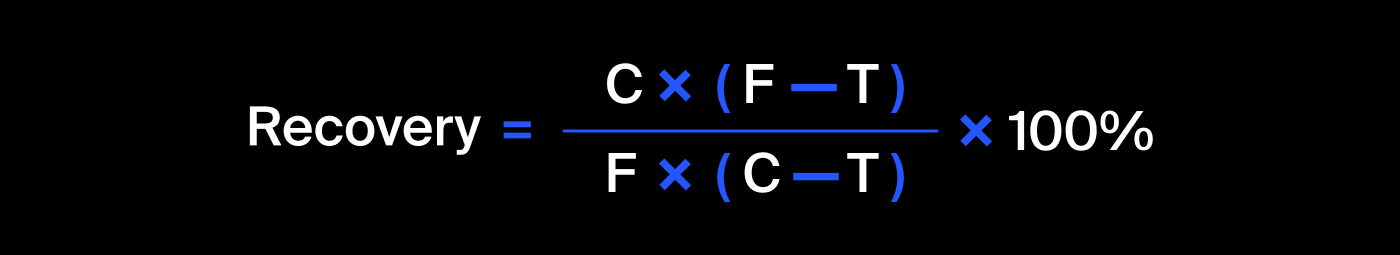

Где:

* C — доля золота в концентрате после флотации/очистки
* F — доля золота в сырье/концентрате до флотации/очистки
* T — доля золота в отвальных хвостах после флотации/очистки

И найдём cреднюю абсолютную ошибку между нашими расчётами и значением признака в столбце. Так мы узнаем верно ли рассчитана эффективность обогащения в нашем признаке. Приступим.

In [10]:
C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

In [11]:
recovery = C * (F - T) / (F * (C - T)) * 100

Отлично. Теперь расчитаем среднюю абсолютную ошибку, т.к. в наших данных есть пропуски и при их удалении пропусков получаются разные размеры наших датафреймов, то тут готовая формула из библиотеки sklearn не подойдёт. Напишем нашу формулу вручную. 

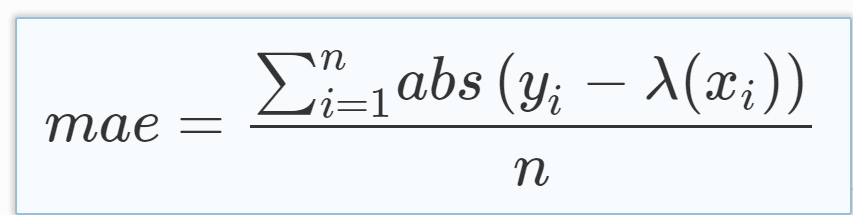

In [12]:
(abs(recovery - train_df['rougher.output.recovery']).sum()) / len(train_df)

8.00350954615662e-15

Как помним, что чем ниже значение, тем лучше. Значит наша эффективность расчитана верно. Переходим к следущему шагу.

<b><font size=4>Анализ признаков, недоступных в тестовой выборке.</font></b><a name="0.2."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Посчитаем сколько у нас недоступных признаков в тестовой выборке.

In [13]:
train_df.shape[1] - test_df.shape[1]

34

Теперь посмотрим на них.

In [14]:
train_df.columns.drop(test_df.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Видим, что в тестовой выборке у нас отсутствуют все этапы на которых были получены параметры продукта из сырья. Условно, конечные значения после  каждого этапа обработки. Это говорит нам о том, что мы должны удалить из train все, чего нету в test, иначе мы не построим проверяемую модель. Переходим к следующему этапу.

<b><font size=4>Предобработка данных</font></b><a name="0.3."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Для начала удалим строки с пропусками в целевом признаке, а позже и сами не нужные нам столбцы.

In [15]:
train_df.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)

In [16]:
drop_test = train_df.columns.drop(test_df.columns)

In [17]:
train_df.drop(drop_test, axis=1, inplace=True)

И преобразуем дату в индекс

In [18]:
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)
full_df.set_index('date', inplace=True)

Сначала удалим строки с пропущенным целевым прзнаком, а после заполним пропуски c помощью метода k-ближайших соседей

In [19]:
def transform_imputer(data, n_neighbors):

    data_columns = data.columns
    index = data.index
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit_transform(data)
    

    return pd.DataFrame(imputer.fit_transform(data), columns=data_columns, index=index)

In [20]:
new_train_df = transform_imputer(train_df, 5)
new_test_df = transform_imputer(test_df, 5)

In [21]:
print('Колличество пропусков до обработки данных в обучающей выборке:', train_df.isnull().sum().sum())
print('Колличество пропусков после обработки данных в обучающей выборке:', new_train_df.isnull().sum().sum())
print('Колличество пропусков до обработки данных в тестовой выборке:', test_df.isnull().sum().sum())
print('Колличество пропусков после обработки данны в тествой выборке:', new_test_df.isnull().sum().sum())

Колличество пропусков до обработки данных в обучающей выборке: 1705
Колличество пропусков после обработки данных в обучающей выборке: 0
Колличество пропусков до обработки данных в тестовой выборке: 2360
Колличество пропусков после обработки данны в тествой выборке: 0


Пропуски заполнены. Лишние признаки удалены и смело перейдём к следующему шагу.

<b><font size=5>Анализ данных</font></b><a name="1."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

<b><font size=4>Анализ концентрации металлов на различных этапах очистки.</font></b><a name="1.1."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Итак, чтобы в ручную не искать в в 87 столбцах нужные нам значения отберём их по названию металла в столбцах.

In [22]:
full_df.columns[full_df.columns.str.endswith('au')], full_df.columns[full_df.columns.str.endswith('ag')],\
full_df.columns[full_df.columns.str.endswith('pb')]

(Index(['final.output.concentrate_au', 'final.output.tail_au',
        'primary_cleaner.output.concentrate_au',
        'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
        'rougher.output.concentrate_au', 'rougher.output.tail_au',
        'secondary_cleaner.output.tail_au'],
       dtype='object'),
 Index(['final.output.concentrate_ag', 'final.output.tail_ag',
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
        'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
        'secondary_cleaner.output.tail_ag'],
       dtype='object'),
 Index(['final.output.concentrate_pb', 'final.output.tail_pb',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.tail_pb', 'rougher.input.feed_pb',
        'rougher.output.concentrate_pb', 'rougher.output.tail_pb',
        'secondary_cleaner.output.tail_pb'],
       dtype='object'))

Теперь так куда проще искать. Отберём нужные нам столбцы, а именно:
*  сырьё в исходном виде
*  после флотации
*  после первичной обработки
*  финальный концентрат.

In [23]:
AU = full_df[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
            'final.output.concentrate_au']].dropna()
AG = full_df[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
            'final.output.concentrate_ag']].dropna()
PB = full_df[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
            'final.output.concentrate_pb']].dropna()

Теперь посмотрим как меняется концентрация металлов на разных стадиях очистки.

In [24]:
print('Концентрация до флотации:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['rougher.input.feed_ag'].median(),
PB['rougher.input.feed_pb'].median(),
AU['rougher.input.feed_au'].median()))
print()
print('Концентрация после флотации:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['rougher.output.concentrate_ag'].median(),
PB['rougher.output.concentrate_pb'].median(),
AU['rougher.output.concentrate_au'].median()))
print()
print('Концентрация после первичной очистки:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['primary_cleaner.output.concentrate_ag'].median(),
PB['primary_cleaner.output.concentrate_pb'].median(),
AU['primary_cleaner.output.concentrate_au'].median()))
print()
print('Финальный концентрат:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['final.output.concentrate_ag'].median(),
PB['final.output.concentrate_pb'].median(),
AU['final.output.concentrate_au'].median()))

Концентрация до флотации:
серебро: 8.30, свинец: 3.44, золото: 7.89

Концентрация после флотации:
серебро: 11.79, свинец: 7.59, золото: 20.00

Концентрация после первичной очистки:
серебро: 8.27, свинец: 9.94, золото: 32.36

Финальный концентрат:
серебро: 4.96, свинец: 9.95, золото: 44.66


Text(0.5, 1.0, 'Изменение концентрации золота после разных этапов обработки')

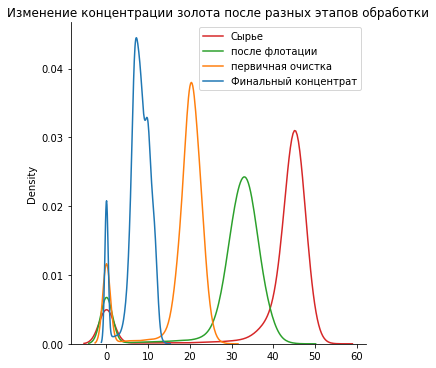

In [25]:
sns.displot(AU, legend=False, kind='kde')
plt.legend(['Сырье', 'после флотации', 'первичная очистка', 'Финальный концентрат'], fontsize=10)
plt.title('Изменение концентрации золота после разных этапов обработки')

Text(0.5, 1.0, 'Изменение концентрации свинца после разных этапов обработки')

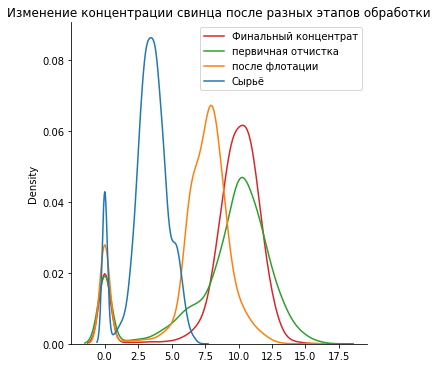

In [26]:
sns.displot(PB, legend=False, kind='kde')
plt.legend(['Финальный концентрат', 'первичная отчистка', 'после флотации', 'Сырьё'], fontsize=10)
plt.title('Изменение концентрации свинца после разных этапов обработки')

Text(0.5, 1.0, 'Изменение концентрации серебра после разных этапов обработки')

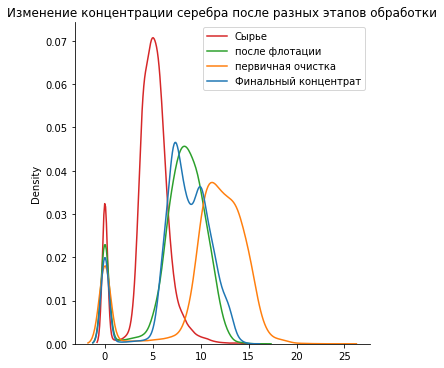

In [27]:
sns.displot(AG, legend=False, kind='kde')
plt.legend(['Сырье', 'после флотации', 'первичная очистка', 'Финальный концентрат'], fontsize=10)
plt.title('Изменение концентрации серебра после разных этапов обработки')

Итак, можно наблюдать что с каждым этапом очистки концентрация золота заметно увеличивается, в то время как концентрация серебра наоборот снижается. Свинец показывает небольшое увелечение концентрации. Приступим к следующему шагу.

<b><font size=4>Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.</font></b><a name="1.2."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Text(0, 0.5, 'соотношение')

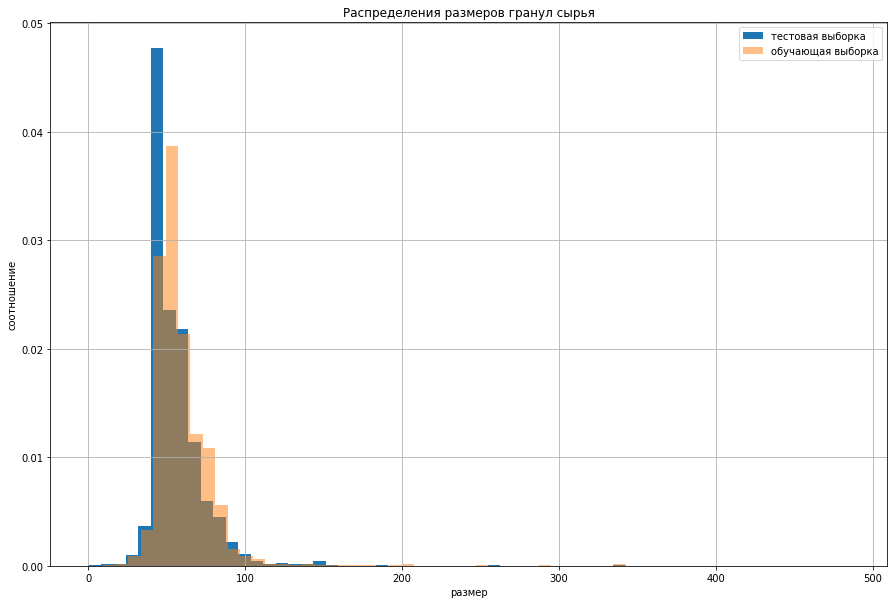

In [28]:
new_test_df['rougher.input.feed_size'].hist(figsize=(15, 10), bins=60, alpha=1, density=True)
new_train_df['rougher.input.feed_size'].hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
plt.legend(['тестовая выборка', 'обучающая выборка'])
plt.title('Распределения размеров гранул сырья')
plt.xlabel('размер')
plt.ylabel('соотношение')

распределения не сильно отличаются друг от друга, оценка модели будет правильной. Перейдём к следующему шагу

<b><font size=4>суммарная концентрация всех веществ на разных стадиях</font></b><a name="1.3."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

In [29]:
feed_concentrate = full_df['rougher.input.feed_ag'] + full_df['rougher.input.feed_pb'] +\
            full_df['rougher.input.feed_sol'] + full_df['rougher.input.feed_au']
rougher_concentrate = full_df['rougher.output.concentrate_ag'] + full_df['rougher.output.concentrate_pb'] +\
            full_df['rougher.output.concentrate_sol'] + full_df['rougher.output.concentrate_au']
final_concentrate = full_df['final.output.concentrate_ag'] + full_df['final.output.concentrate_pb'] +\
            full_df['final.output.concentrate_sol'] + full_df['final.output.concentrate_au']

Text(0, 0.5, 'соотношение')

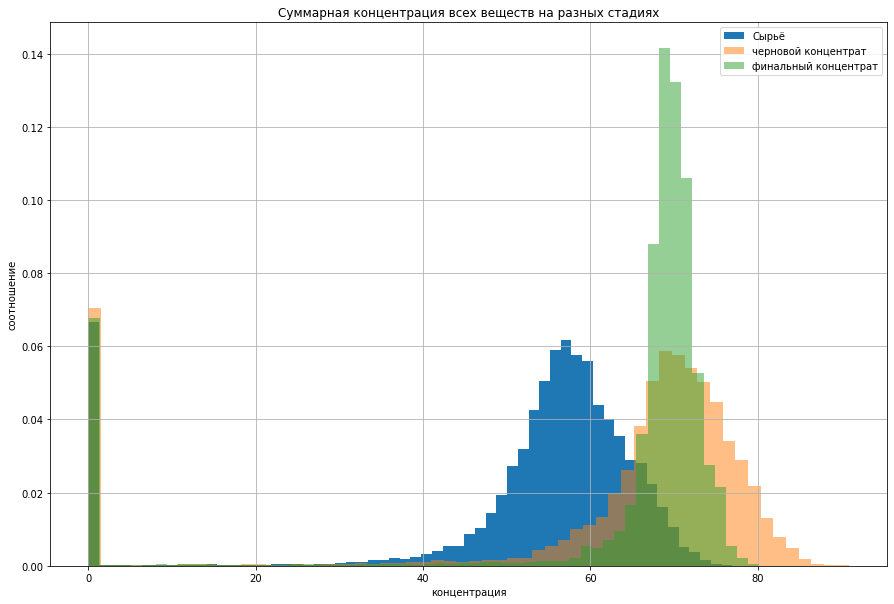

In [30]:
feed_concentrate.hist(figsize=(15, 10), bins=60, alpha=1, density=True)
rougher_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
final_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
plt.legend(['Сырьё', 'черновой концентрат', 'финальный концентрат'])
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlabel('концентрация')
plt.ylabel('соотношение')

Видим, что аномальные значения лежат где-то возле нуля. Так что где-то до 25 можно смело удалить для построения более точной модели, но для сырья поставим значение меньше 1, т.к. мы не знаем в каком виде может поступать сырьё на производство.

In [31]:
full_df = full_df.query('@feed_concentrate > 1 & @rougher_concentrate > 25 & @final_concentrate > 25')

Теперь подготовим наши выборки для обучения. Для этого добавим целевые признаки по индексам. Чтобы индексы в обеих выборках совпадали. Так мы отберём из трейна выбросы, которые мы обнаружили в полной выборке. Тоже самое действие проделаем и с тестовой выборкой.

In [32]:
good_df_for_train = pd.merge(new_train_df, full_df[['rougher.output.recovery', 'final.output.recovery']],
        left_index=True, right_index=True)

Теперь сравним их. 

In [33]:
print('Колличество строк до объединения в обучающей выборке', new_train_df.shape[0])
print('Колличество строк после объединения в обучающей выборке', good_df_for_train.shape[0])

Колличество строк до объединения в обучающей выборке 14149
Колличество строк после объединения в обучающей выборке 13348


Сделаем тоже самое и с тестовой выборкой.

In [34]:
good_df_for_test = pd.merge(new_test_df, full_df[['rougher.output.recovery', 'final.output.recovery']],
         left_index=True, right_index=True)

In [35]:
print('Колличество строк до объединения в тестовой выборке', new_test_df.shape[0])
print('Колличество строк после объединения в тестовой выборке', good_df_for_test.shape[0])

Колличество строк до объединения в тестовой выборке 5856
Колличество строк после объединения в тестовой выборке 5210


Теперь перед тем как перейти к следующему шагу посмотрим есть ли у нас пропуски и если их немного, то просто удалим их.

In [36]:
good_df_for_train.isnull().sum().sum()

0

Пропуски отсутствуют. Переходим к следующему шагу.

<b><font size=5>Построение модели</font></b><a name="2."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

Для начала разделим нашу выборку на признаки и целевые признаки.

In [37]:
x_train = good_df_for_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher = good_df_for_train['rougher.output.recovery']
y_train_final = good_df_for_train['final.output.recovery']
x_test = good_df_for_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test_rougher = good_df_for_test['rougher.output.recovery']
y_test_final = good_df_for_test['final.output.recovery']

Перед обучением модели напишем функции для наших метрик и приступим к обучению.

<b><font size=4>Метрики</font></b><a name="2.1."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

* sMAPE 


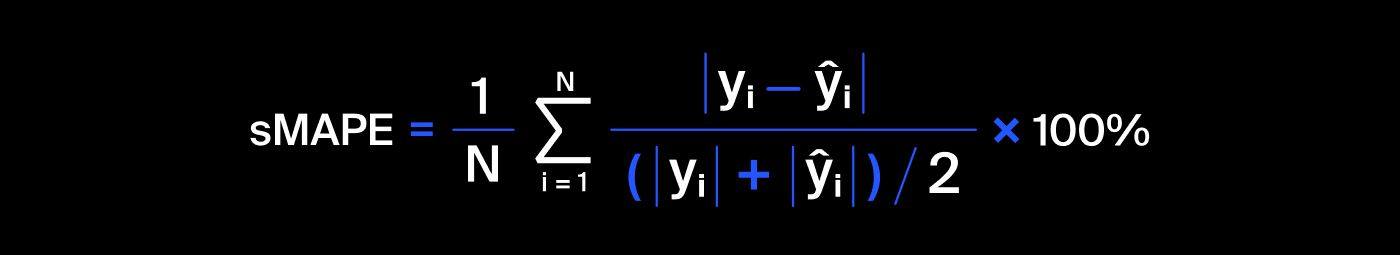

In [38]:
def sMAPE(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

* Итоговый sMAPE 

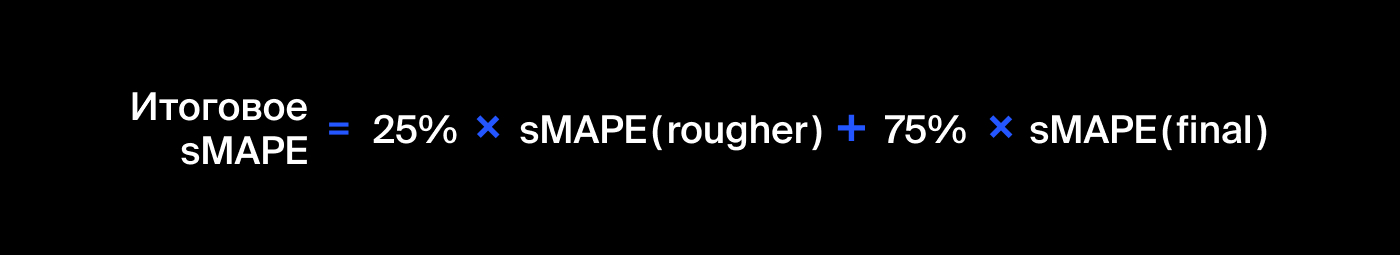

In [39]:
def the_total_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

In [40]:
smape_score = make_scorer(sMAPE, greater_is_better=False)

<b><font size=4>Обучение модели и оценка качества</font></b><a name="2.2."></a>

[<font size="2">(к содержанию)</font>](#to_content.)


Автоматизируем наш процесс обучения с помощью пайплайна.

In [41]:
lasso_model = make_pipeline(StandardScaler(), Lasso(random_state=42))
forestregressor_model = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
treeregressor_model = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))

Теперь, чтобы передать параметры для кросс-валидации посмотрим как они именуются у каждой модели.

In [42]:
lasso_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'lasso', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [43]:
forestregressor_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [44]:
forestregressor_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

Передаём параметры.

In [45]:
forestregressor_params = {'randomforestregressor__n_estimators':range(10, 61, 10),
             'randomforestregressor__max_depth':range (1,10)}
treeregressor_params= {'decisiontreeregressor__max_depth':range (1,10)}
lasso_params = {'lasso__alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

Напишем кросс-валидацию для Лассо - модели

In [46]:
grid_rougher_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)
grid_final_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)

Теперь для леса

In [47]:
grid_rougher_forestregressor = RandomizedSearchCV(forestregressor_model, cv=5, param_distributions = forestregressor_params,
                                            scoring = smape_score, n_jobs=-1)
grid_final_forestregressor = RandomizedSearchCV(forestregressor_model, cv=5, param_distributions = forestregressor_params,
                                          scoring=smape_score, n_jobs=-1)

И для деревьев

In [48]:
grid_rougher_treeregressor = RandomizedSearchCV(treeregressor_model, cv=5, param_distributions = treeregressor_params, 
                                          scoring=smape_score, n_jobs=-1)
grid_final_treeregressor = RandomizedSearchCV(treeregressor_model, cv=5, param_distributions = treeregressor_params, 
                                        scoring=smape_score, n_jobs=-1)

Обучим наши модели и глянем на лучшие параметры.

In [49]:
grid_rougher_lasso.fit(x_train,y_train_rougher)
grid_final_lasso.fit(x_train,y_train_final)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('lasso',
                                              Lasso(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': [0.02, 0.024, 0.025,
                                                         0.026, 0.03]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [50]:
grid_rougher_lasso.best_score_

-5.817354892513924

In [51]:
grid_final_lasso.best_score_

-9.095678782737597

In [52]:
grid_rougher_forestregressor.fit(x_train,y_train_rougher)
grid_final_forestregressor.fit(x_train,y_train_final)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(1, 10),
                                        'randomforestregressor__n_estimators': range(10, 61, 10)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [53]:
grid_rougher_forestregressor.best_score_

-7.441111626896119

In [54]:
grid_final_forestregressor.best_score_

-8.403741734860796

In [55]:
grid_rougher_treeregressor.fit(x_train,y_train_rougher)
grid_final_treeregressor.fit(x_train,y_train_final)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': range(1, 10)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [56]:
grid_rougher_treeregressor.best_score_

-6.962841278268236

In [57]:
grid_final_treeregressor.best_score_

-9.01422974985879

Пока самые лучшие параметры у Лассо модели. Посмотрим на финальную оценку и выберем самую минимальную

In [58]:
the_total_sMAPE(grid_rougher_lasso.best_score_, grid_final_lasso.best_score_)

-8.276097810181678

In [59]:
the_total_sMAPE(grid_rougher_forestregressor.best_score_, grid_final_forestregressor.best_score_)

-8.163084207869627

In [60]:
the_total_sMAPE(grid_rougher_treeregressor.best_score_, grid_final_treeregressor.best_score_)

-8.501382631961151

Выбираем Лассо и смотрим результаты на тестовой выборке.

In [61]:
rougher_pred = grid_rougher_lasso.predict(x_test)
final_pred = grid_final_lasso.predict(x_test)

In [62]:
the_total_sMAPE(sMAPE(y_test_rougher,rougher_pred),sMAPE(y_test_final,final_pred))

6.904852058046297

Ну собственно вот. Оценка получена. Теперь напишем константную модель и посмотрим верно ли предсказывает наша модель. Пусть наша константная модель предсказывает средние значения.

In [63]:
constant_rougher = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))
constant_final = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))

Теперь обучим ещё на наших выборках

In [64]:
constant_rougher.fit(x_train,y_train_rougher)
constant_final.fit(x_train,y_train_final)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dummyregressor', DummyRegressor())])

In [65]:
constant_rougher_pred = constant_rougher.predict(x_test)
constant_final_pred = constant_final.predict(x_test)

In [66]:
the_total_sMAPE(sMAPE(y_test_rougher,constant_rougher_pred),sMAPE(y_test_final,constant_final_pred))

7.536670764862187

Видим, что наша метрика получилась ниже, чем на константной модели. Значит мы сделали всё верно.

<b><font size=5>Общий вывод</font></b><a name="3."></a>

[<font size="2">(к содержанию)</font>](#to_content.)

1) Данные были подготовлены, проанализированы и подготовлены к обучению.

2) лучше всего себя показала Лассо модель. У неё наименьшая из всех моделей ошибка, а так же константная модель, которая предсказывала средние значения оказалась немного хуже, чем модель Лассо.